In [245]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint
import numpy as np
from pandas.tseries.offsets import MonthEnd
import seaborn as sns

In [246]:
# ----------------------------
# Load and Clean NGL Data
# ----------------------------

def load_ngl_data(filepath):
    xl = pd.ExcelFile(filepath)
    sheets = xl.sheet_names
    print(f"Available Sheets: {sheets}")
    
    ngl_data = {}
    for sheet in sheets:
        df = xl.parse(sheet, header=4)  # Start from row 5 (header=4)
        df = df.rename(columns={df.columns[0]: 'Date'})  # Rename the date column
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')  # Convert date column
        df = df.dropna(subset=['Date'])  # Drop rows where date is NaT

        # Dynamically rename columns based on the commodity prefix
        df.columns = ['Date'] + [f"{sheet}{i+1} Comdty" for i in range(len(df.columns)-1)]

        ngl_data[sheet] = df
    
    return ngl_data

# File path
ngl_filepath = '/Users/markbogorad/Desktop/NYU_MFE/Semester_2/1.2_Trading_Energy_Derivatives_MATH_GA_2800/Oil_Project/Systematic_Energy_Trading/Data/NGLs.xlsx'

# Load the data
ngl_datasets = load_ngl_data(ngl_filepath)

# Display one of the datasets to verify
for key, df in ngl_datasets.items():
    print(f"\nFirst few rows of sheet: {key}")
    print(df.head())
    break  # Display only the first sheet for now


Available Sheets: ['NG', 'CAP', 'BAP', 'DAE', 'IBD', 'MMB', 'PCW', 'PGP']

First few rows of sheet: NG
        Date  NG1 Comdty  NG2 Comdty  NG3 Comdty  NG4 Comdty  NG5 Comdty  \
0 2011-07-07       4.133       4.138       4.168       4.324       4.535   
1 2011-07-08       4.205       4.204       4.231       4.385       4.600   
2 2011-07-11       4.288       4.277       4.302       4.447       4.656   
3 2011-07-12       4.333       4.312       4.335       4.473       4.675   
4 2011-07-13       4.403       4.387       4.411       4.540       4.737   

   NG6 Comdty  NG7 Comdty  NG8 Comdty  NG9 Comdty  ...  NG15 Comdty  \
0       4.642       4.644       4.608       4.525  ...        4.706   
1       4.709       4.710       4.673       4.586  ...        4.769   
2       4.764       4.765       4.728       4.642  ...        4.824   
3       4.783       4.782       4.741       4.654  ...        4.834   
4       4.845       4.843       4.796       4.706  ...        4.882   

   NG16 Comdt

In [247]:
# ----------------------------
# Convert Petrochemical Units (Multiply by Density)
# ----------------------------

def convert_all_units(ngl_data):
    # Petrochemical densities for conversion
    densities = {
        'PCW': 4.91,  # Ethylene
        'PGP': 4.16   # Propylene
    }

    for sheet in ngl_data:
        if sheet in densities:
            for col in ngl_data[sheet].columns:
                if 'Comdty' in col:
                    ngl_data[sheet][col] = ngl_data[sheet][col] * densities[sheet]
                    print(f"Converted {col} in {sheet} using density {densities[sheet]}")

    return ngl_data

In [248]:
# ----------------------------
# Construct Specified Spreads (22 day lag)
# ----------------------------

def construct_spreads(ngl_data):
    spreads = {}
    
    spread_pairs = {
        'Ethane-Ethylene': ('CAP1 Comdty', 'PCW1 Comdty'),
        'Propane-Ethylene': ('BAP1 Comdty', 'PCW1 Comdty'),
        'Propane-Propylene': ('BAP1 Comdty', 'PGP1 Comdty'),
        'Butane-Ethylene': ('DAE1 Comdty', 'PCW1 Comdty'),
        'Butane-Propylene': ('DAE1 Comdty', 'PGP1 Comdty')
    }

    for spread_name, (ngl_col, petro_col) in spread_pairs.items():
        # Extract and align data
        ngl_df = ngl_data[ngl_col[:3]][['Date', ngl_col]].set_index('Date')
        petro_df = ngl_data[petro_col[:3]][['Date', petro_col]].set_index('Date')

        # Shift NGL price backward to simulate processing lag
        ngl_df[f'{ngl_col}_shifted'] = ngl_df[ngl_col].shift(22)

        # Join and calculate spread
        spread_df = petro_df.join(ngl_df[[f'{ngl_col}_shifted']], how='inner')
        spread_df['Spread'] = spread_df[petro_col] - spread_df[f'{ngl_col}_shifted']

        # Drop NaNs and report data loss
        initial_count = spread_df.shape[0]
        spread_df = spread_df.dropna(subset=['Spread']).reset_index()
        final_count = spread_df.shape[0]
        print(f"{spread_name}: Retained {final_count}/{initial_count} observations after shifting and joining.")

        # Save the cleaned spread data
        spreads[spread_name] = spread_df[['Date', 'Spread']]

    return spreads


Available Sheets: ['NG', 'CAP', 'BAP', 'DAE', 'IBD', 'MMB', 'PCW', 'PGP']
Converted PCW1 Comdty in PCW using density 4.91
Converted PCW2 Comdty in PCW using density 4.91
Converted PCW3 Comdty in PCW using density 4.91
Converted PCW4 Comdty in PCW using density 4.91
Converted PCW5 Comdty in PCW using density 4.91
Converted PCW6 Comdty in PCW using density 4.91
Converted PCW7 Comdty in PCW using density 4.91
Converted PCW8 Comdty in PCW using density 4.91
Converted PCW9 Comdty in PCW using density 4.91
Converted PCW10 Comdty in PCW using density 4.91
Converted PCW11 Comdty in PCW using density 4.91
Converted PCW12 Comdty in PCW using density 4.91
Converted PCW13 Comdty in PCW using density 4.91
Converted PCW14 Comdty in PCW using density 4.91
Converted PCW15 Comdty in PCW using density 4.91
Converted PCW16 Comdty in PCW using density 4.91
Converted PCW17 Comdty in PCW using density 4.91
Converted PCW18 Comdty in PCW using density 4.91
Converted PCW19 Comdty in PCW using density 4.91
Conv

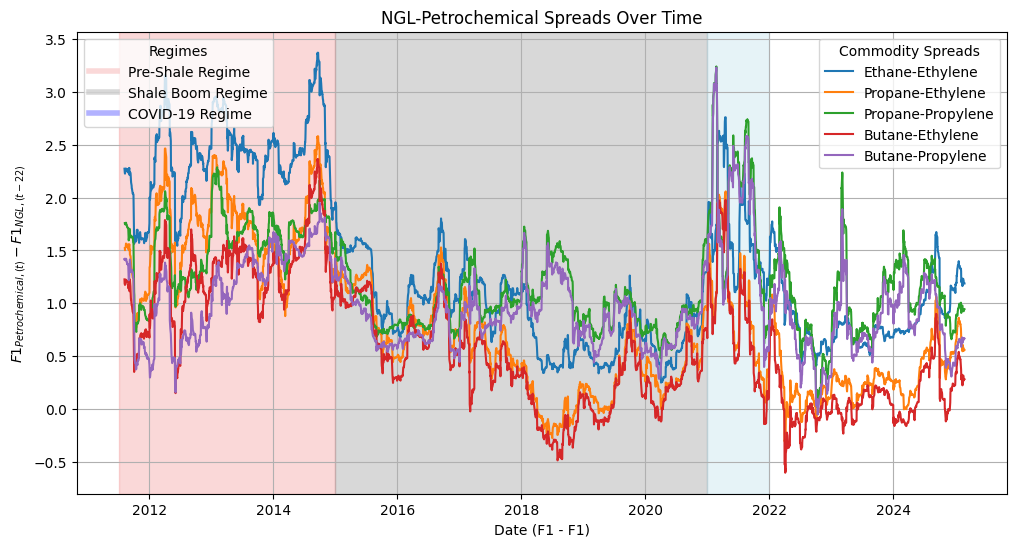

In [249]:
# ----------------------------
# Plot spreads and highlight regimes
# ----------------------------

def plot_spreads(spreads):
    plt.figure(figsize=(12, 6))
    
    # Plot spreads for each commodity pair
    commodity_handles = []
    for key, df in spreads.items():
        line, = plt.plot(df['Date'], df['Spread'], label=key)
        commodity_handles.append(line)

    # Highlight regimes with different colors
    plt.axvspan('2011-07-07', '2014-12-31', color='lightcoral', alpha=0.3)
    plt.axvspan('2015-01-01', '2021-01-01', color='gray', alpha=0.3)
    plt.axvspan('2021-01-01', '2022-01-01', color='lightblue', alpha=0.3)

    # Create legends
    regime_patches = [
        plt.Line2D([0], [0], color='lightcoral', lw=4, alpha=0.3, label='Pre-Shale Regime'),
        plt.Line2D([0], [0], color='gray', lw=4, alpha=0.3, label='Shale Boom Regime'),
        plt.Line2D([0], [0], color='blue', lw=4, alpha=0.3, label='COVID-19 Regime')
    ]

    first_legend = plt.legend(handles=commodity_handles, title="Commodity Spreads", loc='upper right')
    plt.gca().add_artist(first_legend)
    plt.legend(handles=regime_patches, title="Regimes", loc='upper left')

    plt.xlabel('Date (F1 - F1)')
    plt.ylabel(r'$F1_{Petrochemical,(t)} - F1_{NGL,(t-22)}$')
    plt.title('NGL-Petrochemical Spreads Over Time')
    plt.grid()
    plt.show()
# ----------------------------
# Run the Full Process
# ----------------------------

ngl_datasets = load_ngl_data(ngl_filepath)
ngl_datasets = convert_all_units(ngl_datasets)
ngl_spreads = construct_spreads(ngl_datasets)

# Display and plot
for key, df in ngl_spreads.items():
    print(f"\nFirst few rows for spread: {key}")
    print(df.head())

plot_spreads(ngl_spreads)


In [250]:
# ----------------------------
# Intra-Spread Cointegration Test
# ----------------------------

def engle_granger_intra_test(ngl_data):
    results = []
    spread_pairs = {
        'Ethane-Ethylene': ('CAP1 Comdty', 'PCW1 Comdty'),
        'Propane-Ethylene': ('BAP1 Comdty', 'PCW1 Comdty'),
        'Propane-Propylene': ('BAP1 Comdty', 'PGP1 Comdty'),
        'Butane-Ethylene': ('DAE1 Comdty', 'PCW1 Comdty'),
        'Butane-Propylene': ('DAE1 Comdty', 'PGP1 Comdty')
    }

    for spread, (ngl_col, petro_col) in spread_pairs.items():
        try:
            # Extract and shift NGL data
            ngl_series = ngl_data[ngl_col[:3]][['Date', ngl_col]].set_index('Date')[ngl_col].shift(22)
            petro_series = ngl_data[petro_col[:3]][['Date', petro_col]].set_index('Date')[petro_col]

            # Align data with inner join to prevent misalignment
            combined = pd.concat([petro_series, ngl_series], axis=1, join='inner').dropna()
            initial_count = len(petro_series)
            final_count = len(combined)

            # Apply Engle-Granger cointegration test
            score, p_value, _ = coint(combined.iloc[:, 0], combined.iloc[:, 1])

            results.append({
                'Spread': spread,
                'Cointegration Score': round(score, 5),
                'P-Value': round(p_value, 5),
            })

        except KeyError as e:
            print(f"Data missing for {spread}: {e}")

    return pd.DataFrame(results)

# ----------------------------
# Inter-Spread Cointegration Test
# ----------------------------

def engle_granger_inter_test(spreads):
    results = []
    spread_names = list(spreads.keys())

    for i in range(len(spread_names)):
        for j in range(i + 1, len(spread_names)):
            spread1 = spreads[spread_names[i]].set_index('Date')['Spread']
            spread2 = spreads[spread_names[j]].set_index('Date')['Spread']

            # Align data properly
            combined = pd.concat([spread1, spread2], axis=1, join='inner').dropna()
            initial_count = len(spread1)
            final_count = len(combined)

            # Apply cointegration test
            score, p_value, _ = coint(combined.iloc[:, 0], combined.iloc[:, 1])

            results.append({
                'Spread Pair': f"{spread_names[i]} vs {spread_names[j]}",
                'Cointegration Score': round(score, 5),
                'P-Value': round(p_value, 5),
            })

    return pd.DataFrame(results)

# ----------------------------
# Run the Tests
# ----------------------------

# Intra-spread test (within each NGL-petrochemical pair)
intra_results = engle_granger_intra_test(ngl_datasets)
print("\nIntra-Spread Cointegration Test Results:")
print(intra_results)

# Inter-spread test (between spreads)
inter_results = engle_granger_inter_test(ngl_spreads)
print("\nInter-Spread Cointegration Test Results:")
print(inter_results)






Intra-Spread Cointegration Test Results:
              Spread  Cointegration Score  P-Value
0    Ethane-Ethylene             -2.94593  0.12362
1   Propane-Ethylene             -2.79251  0.16808
2  Propane-Propylene             -5.02770  0.00015
3    Butane-Ethylene             -3.36114  0.04685
4   Butane-Propylene             -4.62838  0.00075

Inter-Spread Cointegration Test Results:
                             Spread Pair  Cointegration Score  P-Value
0    Ethane-Ethylene vs Propane-Ethylene             -3.07677  0.09306
1   Ethane-Ethylene vs Propane-Propylene             -3.87669  0.01068
2     Ethane-Ethylene vs Butane-Ethylene             -2.94150  0.12478
3    Ethane-Ethylene vs Butane-Propylene             -2.87392  0.14329
4  Propane-Ethylene vs Propane-Propylene             -3.59014  0.02520
5    Propane-Ethylene vs Butane-Ethylene             -3.45369  0.03673
6   Propane-Ethylene vs Butane-Propylene             -2.75625  0.18000
7   Propane-Propylene vs Butane-Ethylene  

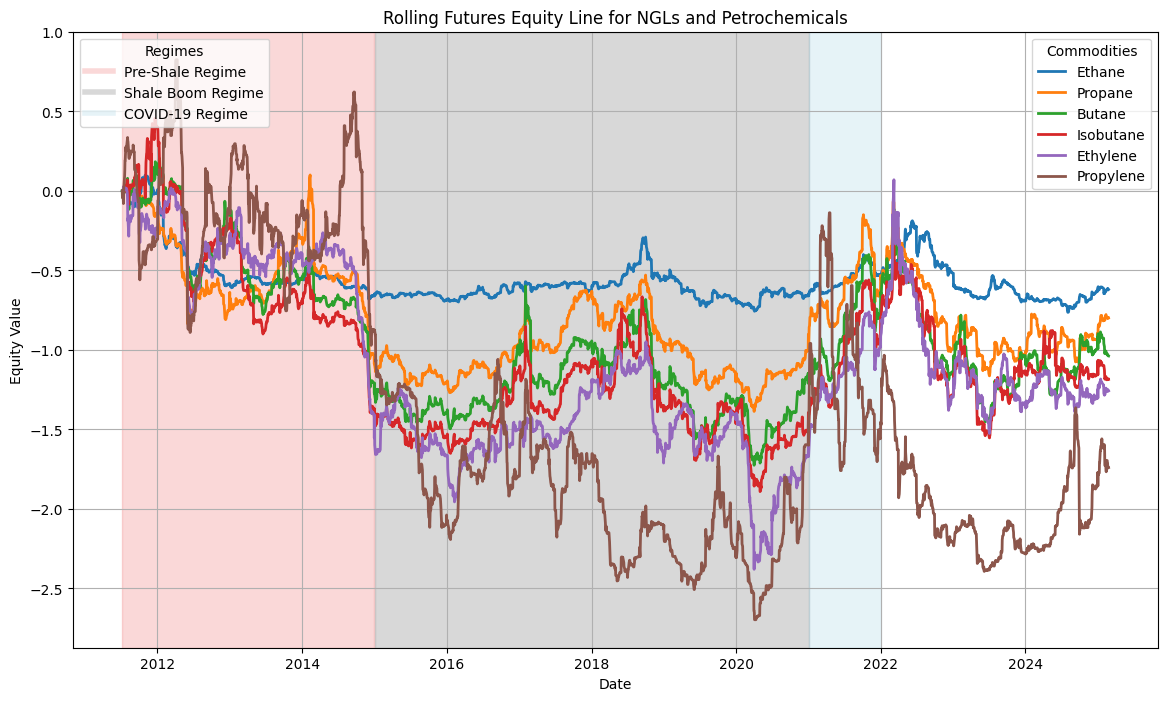

,Sheet,Rolling Futures PnL,Total Transaction Costs
0,CAP,-61951.58200,6858.58200
1,BAP,-79861.06000,19378.06000
2,DAE,-103768.84600,24626.84600
3,IBD,-118472.75600,25867.75600
4,MMB,-125741.95800,35644.95800
5,PCW,-173933.25408,37715.12408


In [251]:
# ----------------------------
# Rolling Futures
# ----------------------------

def define_eom_roll_calendar(df):
    df['Roll'] = (df['Date'] == (df['Date'] + MonthEnd(0))).astype(int)
    df['Action'] = 'Hold'
    df.loc[df.index[0], 'Action'] = 'Buy'
    df.loc[df['Roll'] == 1, 'Action'] = 'Sell & Buy'
    df.loc[df.index[-1], 'Action'] = 'Sell'
    return df

def calculate_eom_rolling_futures(df, transaction_cost=0.002):  # Adjusted to 0.2%
    contract_cols = [col for col in df.columns if col not in ['Date', 'Roll', 'Action']]
    
    rolling_futures = []
    cumulative_costs = []
    total_cost = 0

    # Initialize using the first contract value
    initial_value = df[contract_cols[0]].iloc[0]
    
    for idx in range(len(df)):
        current_value = df[contract_cols[0]].iloc[idx] if df.loc[idx, 'Roll'] == 0 else df[contract_cols[1]].iloc[idx]
        t_cost = transaction_cost * current_value if idx == 0 or df.loc[idx, 'Roll'] == 1 else 0
        
        # Calculate adjusted equity value starting from zero
        adjusted_value = current_value - initial_value - total_cost
        rolling_futures.append(adjusted_value)
        
        # Update transaction costs
        total_cost += t_cost
        cumulative_costs.append(total_cost)

    df['Rolling Futures'] = rolling_futures
    df['Cumulative Transaction Costs'] = cumulative_costs

    return df

def plot_rolling_futures_panel(datasets, name_mapping):
    plt.figure(figsize=(14, 8))
    for ticker, df in datasets.items():
        label = name_mapping.get(ticker, ticker)
        plt.plot(df['Date'], df['Rolling Futures'], label=label, linewidth=2)

    plt.axvspan('2011-07-07', '2014-12-31', color='lightcoral', alpha=0.3)
    plt.axvspan('2015-01-01', '2021-01-01', color='gray', alpha=0.3)
    plt.axvspan('2021-01-01', '2022-01-01', color='lightblue', alpha=0.3)

    regime_patches = [
        plt.Line2D([0], [0], color='lightcoral', lw=4, alpha=0.3, label='Pre-Shale Regime'),
        plt.Line2D([0], [0], color='gray', lw=4, alpha=0.3, label='Shale Boom Regime'),
        plt.Line2D([0], [0], color='lightblue', lw=4, alpha=0.3, label='COVID-19 Regime')
    ]

    first_legend = plt.legend(title="Commodities", loc='upper right')
    plt.gca().add_artist(first_legend)
    plt.legend(handles=regime_patches, title="Regimes", loc='upper left')

    plt.xlabel('Date')
    plt.ylabel('Equity Value')
    plt.title('Rolling Futures Equity Line for NGLs and Petrochemicals')
    plt.grid()
    plt.show()

# ----------------------------
# Execute Full Process
# ----------------------------

ticker_to_commodity = {
    'CAP': 'Ethane',
    'BAP': 'Propane',
    'DAE': 'Butane',
    'IBD': 'Isobutane',
    'MMB': 'Ethylene',
    'PCW': 'Propylene'
}

filtered_datasets = {ticker: df for ticker, df in ngl_datasets.items() if ticker in ticker_to_commodity}

all_metrics = []

for name, df in filtered_datasets.items():
    df = define_eom_roll_calendar(df)
    df = calculate_eom_rolling_futures(df, transaction_cost=0.002)  # 0.2% cost
    metrics = calculate_metrics(df, name)
    all_metrics.append(metrics)

# Plot all commodities in a single panel with correct labels
plot_rolling_futures_panel(filtered_datasets, ticker_to_commodity)

# Convert and display metrics DataFrame
metrics_df = pd.DataFrame(all_metrics)
display(metrics_df)

# Optional: Save metrics to CSV
# metrics_df.to_csv('ngl_metrics_summary.csv', index=False)


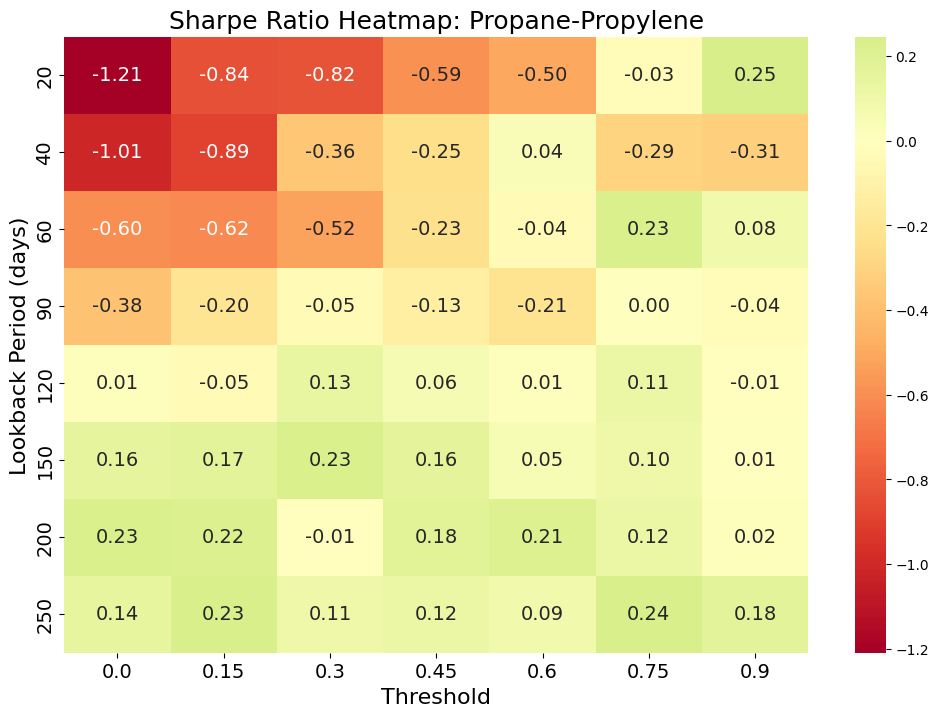


Performance Metrics for Propane-Propylene:
Annualized PnL: 0.0110
Sharpe Ratio: 0.2458
Return on Max Drawdown: 2.2022


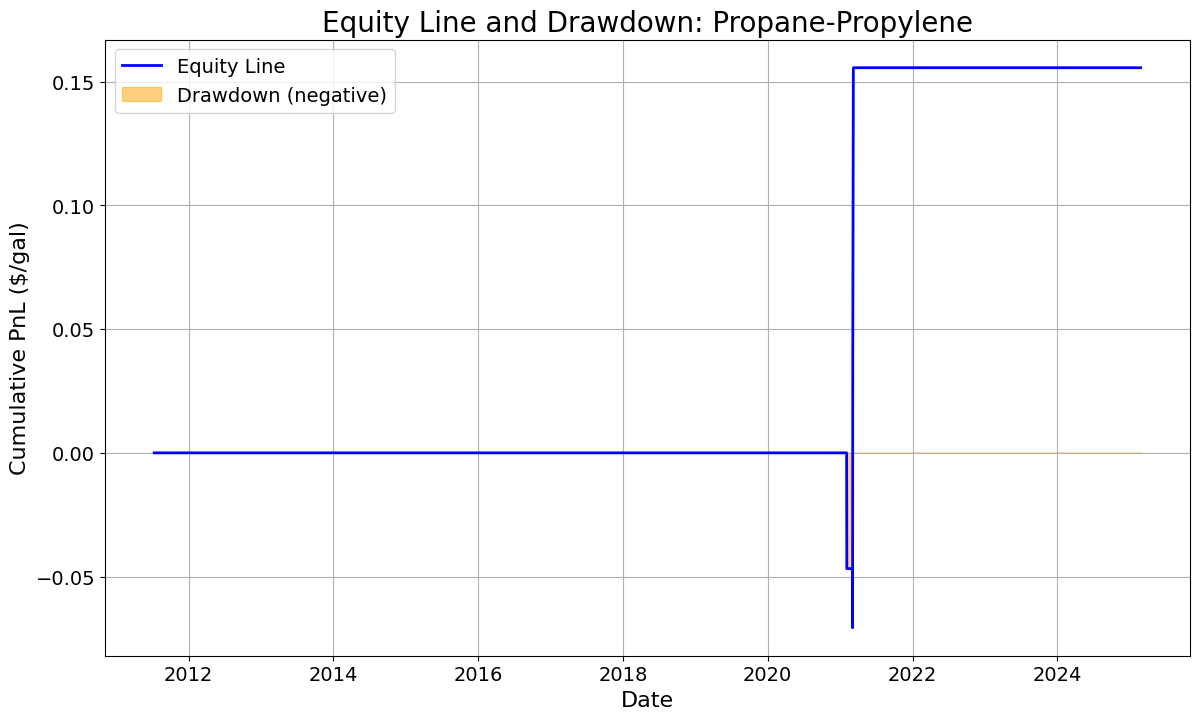

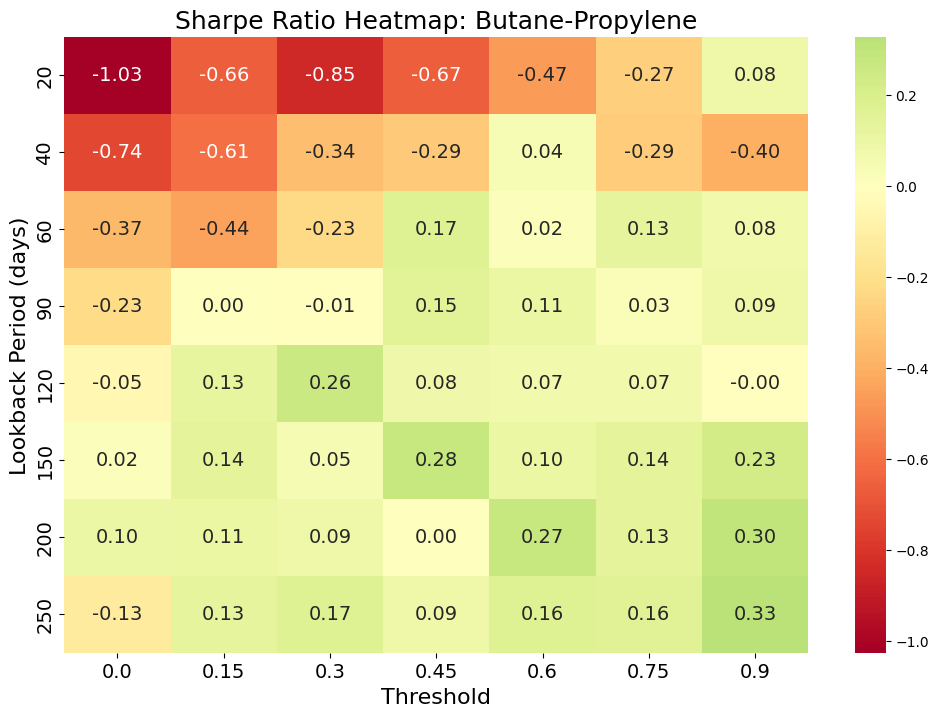


Performance Metrics for Butane-Propylene:
Annualized PnL: 0.0971
Sharpe Ratio: 0.3280
Return on Max Drawdown: 1.8262


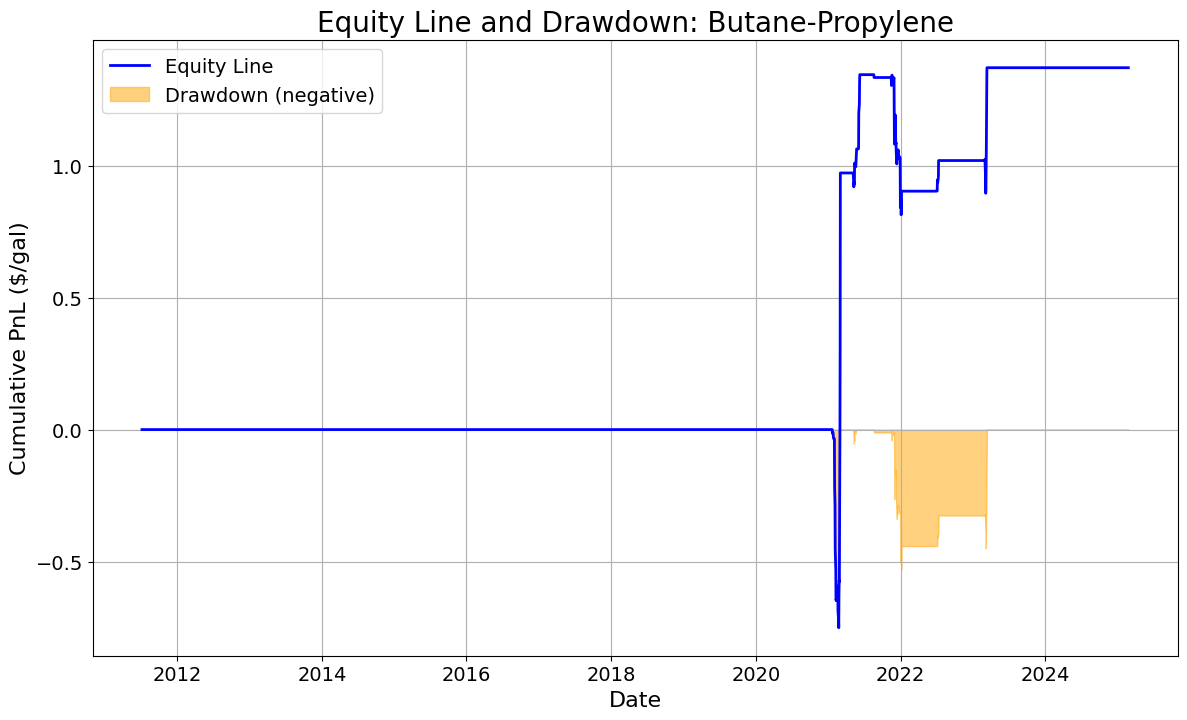

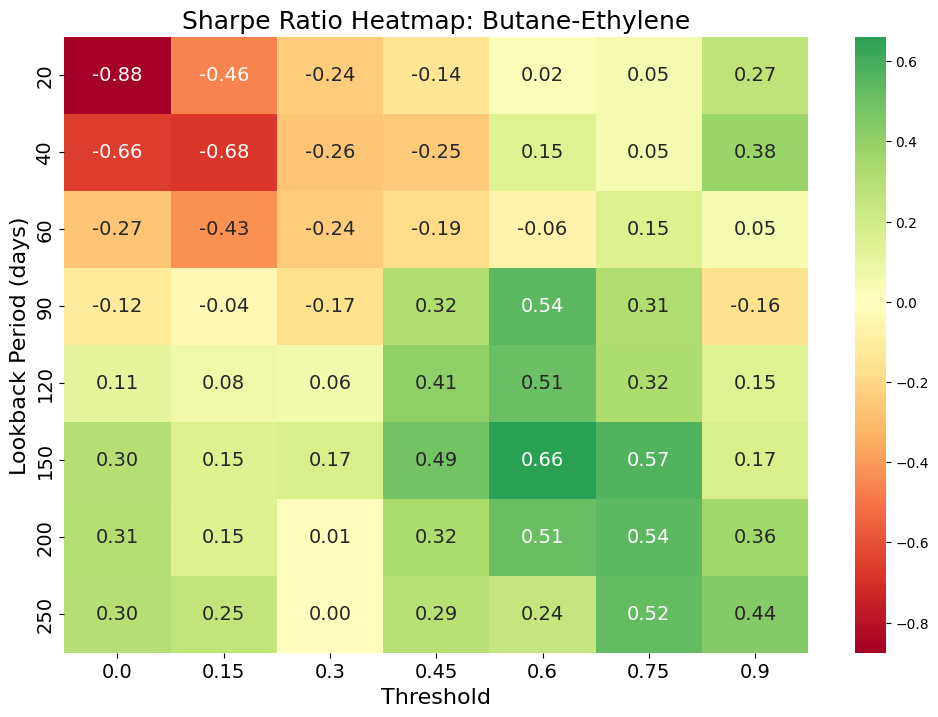


Performance Metrics for Butane-Ethylene:
Annualized PnL: 0.1826
Sharpe Ratio: 0.6607
Return on Max Drawdown: 9.7137


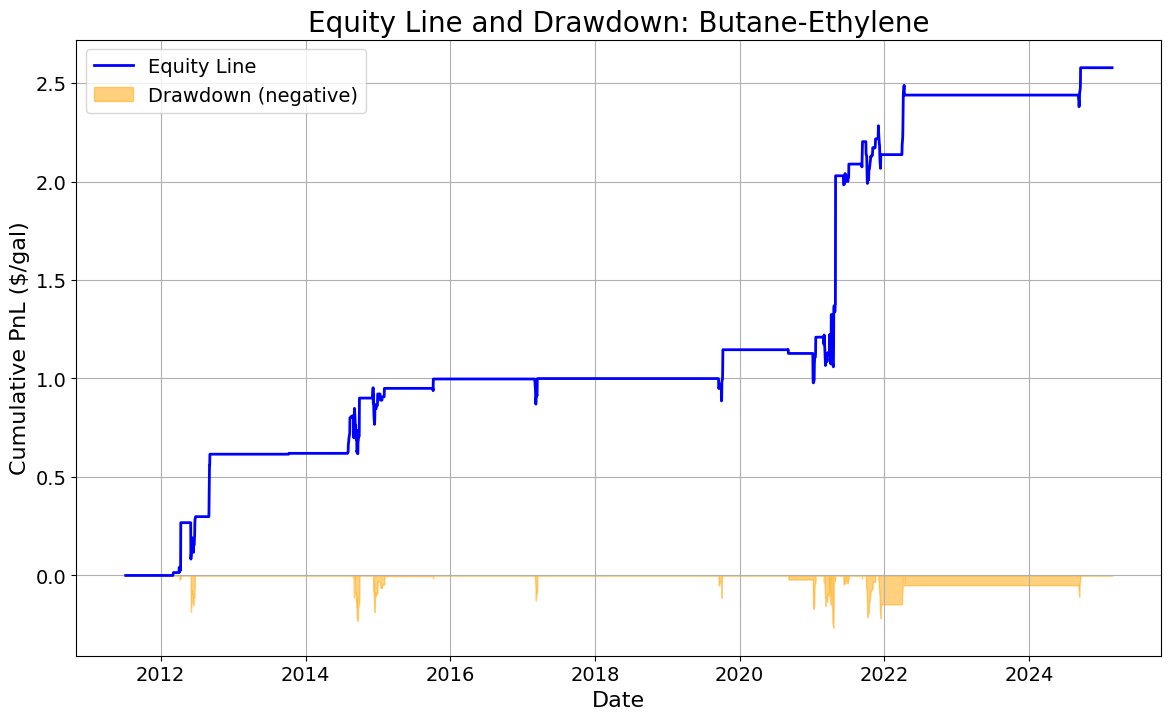

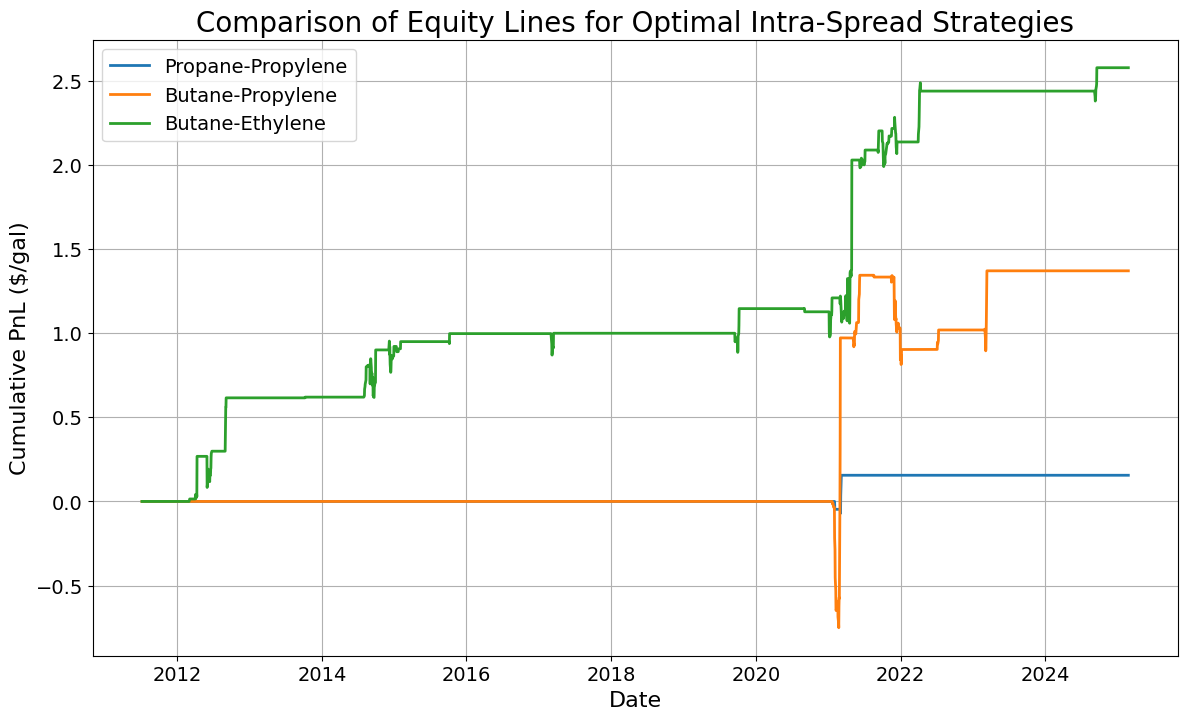

In [259]:
# Intra spread back test

# ----------------------------
# 1. Performance Metrics Calculation
# ----------------------------

def calculate_sharpe_ratio(pnl_series):
    """Calculates the annualized Sharpe Ratio based on daily returns."""
    daily_returns = pnl_series.diff().dropna()
    if daily_returns.empty or daily_returns.std() == 0:
        return 0
    return (daily_returns.mean() / daily_returns.std()) * np.sqrt(252)

def calculate_annualized_pnl(pnl_series):
    """Calculates the annualized PnL based on cumulative returns."""
    pnl_series = pnl_series.dropna()
    if pnl_series.empty or pnl_series.iloc[-1] == pnl_series.iloc[0]:
        return 0
    total_days = len(pnl_series)
    total_return = pnl_series.iloc[-1] - pnl_series.iloc[0]
    return (total_return / total_days) * 252

def calculate_return_on_drawdown(cumulative_pnl):
    """Calculates the return over the maximum drawdown."""
    cumulative_pnl = cumulative_pnl.dropna()
    if cumulative_pnl.empty:
        return 0
    rolling_max = cumulative_pnl.cummax()
    drawdown = cumulative_pnl - rolling_max
    max_drawdown = drawdown.min()
    total_return = cumulative_pnl.iloc[-1] - cumulative_pnl.iloc[0]
    return 0 if max_drawdown == 0 else total_return / abs(max_drawdown)

def generate_strategy_metrics(df, spread_name):
    """Prints performance metrics for a given strategy."""
    cumulative_pnl = df['Cumulative PnL']
    annualized_pnl = calculate_annualized_pnl(cumulative_pnl)
    sharpe_ratio = calculate_sharpe_ratio(cumulative_pnl)
    return_on_dd = calculate_return_on_drawdown(cumulative_pnl)
    
    print(f"\nPerformance Metrics for {spread_name}:")
    print(f"Annualized PnL: {annualized_pnl:.4f}")
    print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
    print(f"Return on Max Drawdown: {return_on_dd:.4f}")

# ----------------------------
# 2. Signal Assignment
# ----------------------------

def assign_trading_signals(df, lookback=30, threshold=0.05):
    # The signal is not lagged here because the next step will explicity lag this whole indicator to use only the info from the day before
    df['MA'] = df['Spread'].rolling(window=lookback).mean()
    df['Signal'] = 0
    df.loc[df['Spread'] > df['MA'] + threshold, 'Signal'] = -1  # Short petrochemical, long NGL
    df.loc[df['Spread'] < df['MA'] - threshold, 'Signal'] = 1   # Long petrochemical, short NGL
    return df

# ----------------------------
# 3. Apply Strategy and Calculate PnL
# ----------------------------

def apply_strategy(df, petro_col, ngl_col, transaction_cost=0.002):
    # Costs incurred today (time t)
    petro_cost = df[petro_col] * transaction_cost
    ngl_cost = df[ngl_col] * transaction_cost

    # Calculate PnL considering today's price movement and transaction cost but using YESTERDAY'S signal to avoid lookahead bias
    df['PnL'] = df['Signal'].shift(1) * (
        (df[petro_col] - df[petro_col].shift(1) - petro_cost) -
        (df[ngl_col] - df[ngl_col].shift(1) - ngl_cost)
    )
    df['Cumulative PnL'] = df['PnL'].cumsum()
    return df

# ----------------------------
# 4. Generate Heatmap Data
# ----------------------------

def generate_heatmap_data(df, lookbacks, thresholds, petro_col, ngl_col):
    """Generates heatmap data by testing different lookbacks and thresholds."""
    heatmap_data = []
    for lookback in lookbacks:
        row = []
        for threshold in thresholds:
            temp_df = assign_trading_signals(df.copy(), lookback=lookback, threshold=threshold)
            temp_df = apply_strategy(temp_df, petro_col, ngl_col)
            sharpe = calculate_sharpe_ratio(temp_df['Cumulative PnL'])
            row.append(sharpe)
        heatmap_data.append(row)
    return pd.DataFrame(heatmap_data, index=lookbacks, columns=thresholds)

# ----------------------------
# 5. Plot Heatmap
# ----------------------------

def plot_sharpe_heatmap(heatmap_df, title):
    """Plots a heatmap of Sharpe ratios for various parameter combinations."""
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_df, annot=True, fmt=".2f", cmap="RdYlGn", center=0, annot_kws={"size": 14})
    plt.title(f'Sharpe Ratio Heatmap: {title}', fontsize=18)
    plt.xlabel('Threshold', fontsize=16)
    plt.ylabel('Lookback Period (days)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

# ----------------------------
# 8. Plot Equity Lines 
# ----------------------------

def plot_combined_performance(df, strategy_name):
    """Plots the cumulative PnL and drawdown for a given strategy."""
    drawdown = df['Cumulative PnL'].cummax() - df['Cumulative PnL']
    plt.figure(figsize=(14, 8))

    plt.plot(df['Date'], df['Cumulative PnL'], label='Equity Line', color='blue', linewidth=2)
    plt.fill_between(df['Date'], -drawdown, 0, color='orange', alpha=0.5, label='Drawdown (negative)')
    plt.xlabel('Date', fontsize=16)
    plt.ylabel('Cumulative PnL ($/gal)', fontsize=16)
    plt.title(f'Equity Line and Drawdown: {strategy_name}', fontsize=20)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=14)
    plt.grid()
    plt.show()



# ----------------------------
# 9. Main Execution Loop with Combined Equity Plot
# ----------------------------
    
ordered_cointegrated_pairs = [
('Propane-Propylene', 'PGP1 Comdty', 'BAP1 Comdty'),
('Butane-Propylene', 'PGP1 Comdty', 'DAE1 Comdty'),
('Butane-Ethylene', 'PCW1 Comdty', 'DAE1 Comdty')
]

lookbacks = [20, 40, 60, 90, 120, 150, 200, 250]
thresholds = [0, 0.15, 0.30, 0.45, 0.60, 0.75, 0.90]

def plot_all_equity_lines(results_dict):
    """Plots the cumulative PnL of all strategies on one chart for comparison."""
    plt.figure(figsize=(14, 8))
    
    for spread_name, df in results_dict.items():
        plt.plot(df['Date'], df['Cumulative PnL'], label=spread_name, linewidth=2)
    
    plt.xlabel('Date', fontsize=16)
    plt.ylabel('Cumulative PnL ($/gal)', fontsize=16)
    plt.title('Comparison of Equity Lines for Optimal Intra-Spread Strategies', fontsize=20)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=14)
    plt.grid()
    plt.show()



# Dictionary to store final DataFrames for each strategy
final_results = {}

for spread_name, petro_col, ngl_col in ordered_cointegrated_pairs:
    try:
        petro_df = define_eom_roll_calendar(ngl_datasets[petro_col[:3]])
        petro_df = calculate_eom_rolling_futures(petro_df, transaction_cost=0.002)

        ngl_df = define_eom_roll_calendar(ngl_datasets[ngl_col[:3]])
        ngl_df = calculate_eom_rolling_futures(ngl_df, transaction_cost=0.002)

        merged_df = pd.merge(
            petro_df[['Date', 'Rolling Futures']],
            ngl_df[['Date', 'Rolling Futures']],
            on='Date',
            suffixes=('_petro', '_ngl')
        )
        merged_df['Spread'] = merged_df['Rolling Futures_petro'] - merged_df['Rolling Futures_ngl'].shift(22)

        heatmap_df = generate_heatmap_data(merged_df, lookbacks, thresholds, 'Rolling Futures_petro', 'Rolling Futures_ngl')
        plot_sharpe_heatmap(heatmap_df, spread_name)

        optimal_params = heatmap_df.stack().idxmax()
        optimal_lookback, optimal_threshold = optimal_params

        final_df = assign_trading_signals(merged_df, lookback=optimal_lookback, threshold=optimal_threshold)
        final_df = apply_strategy(final_df, 'Rolling Futures_petro', 'Rolling Futures_ngl')

        # Store the result for later combined plotting
        final_results[spread_name] = final_df

        generate_strategy_metrics(final_df, spread_name)
        plot_combined_performance(final_df, spread_name)

    except KeyError as e:
        print(f"Data missing for {spread_name}: {e}")

# Plot all equity lines together
plot_all_equity_lines(final_results)

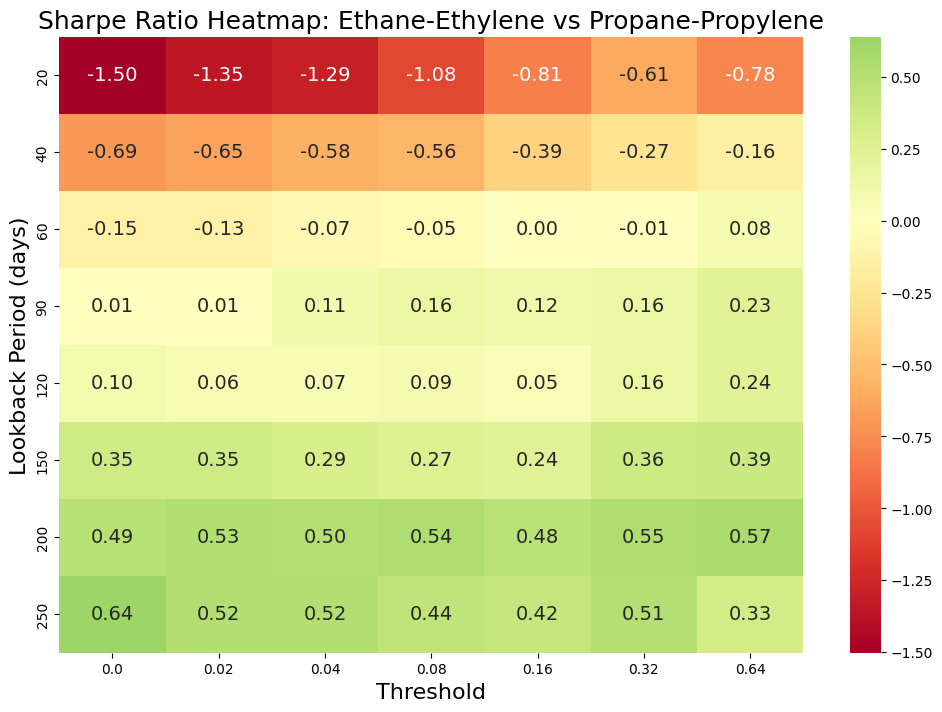


Performance Metrics for Ethane-Ethylene vs Propane-Propylene:
Annualized PnL: 0.6440
Sharpe Ratio: 0.6388
Return on Max Drawdown: 5.1889


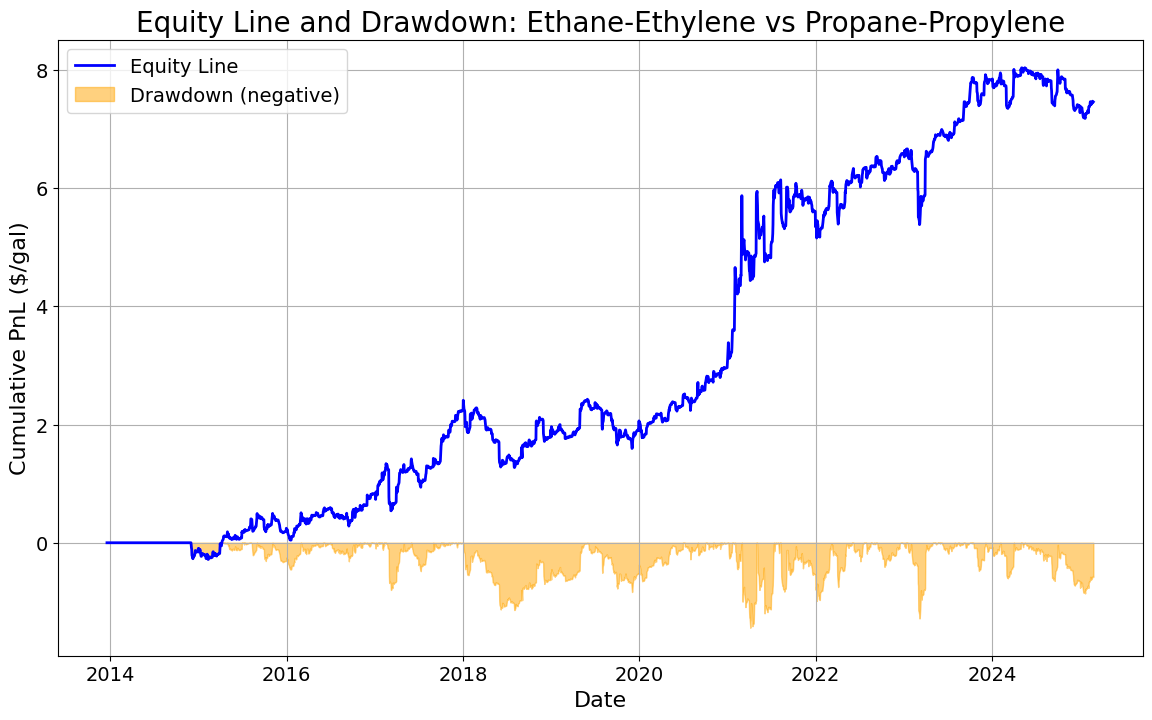

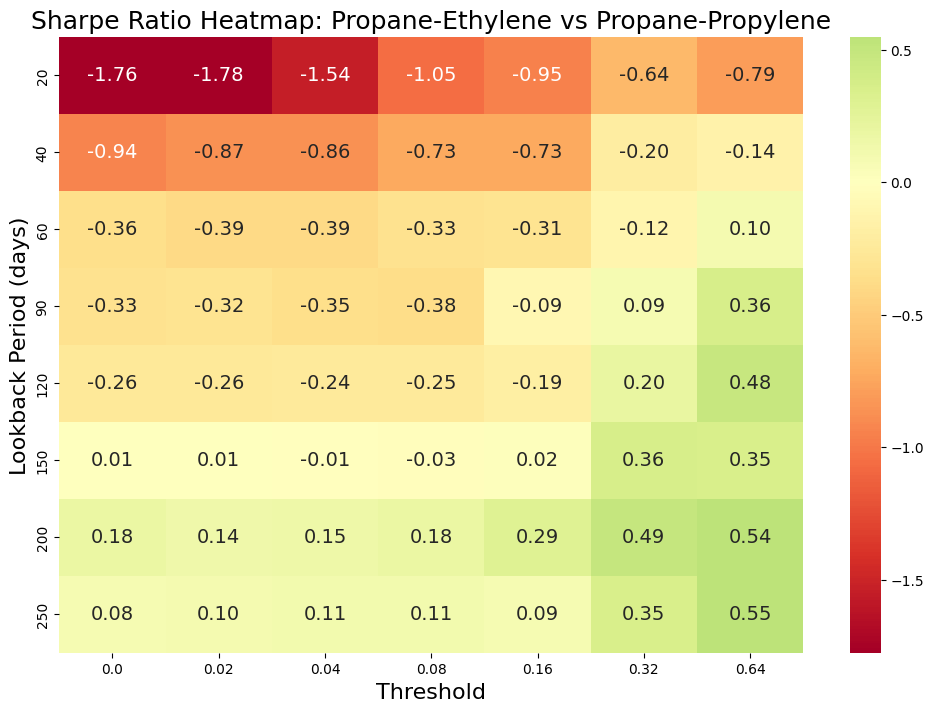


Performance Metrics for Propane-Ethylene vs Propane-Propylene:
Annualized PnL: 0.3506
Sharpe Ratio: 0.5486
Return on Max Drawdown: 5.1293


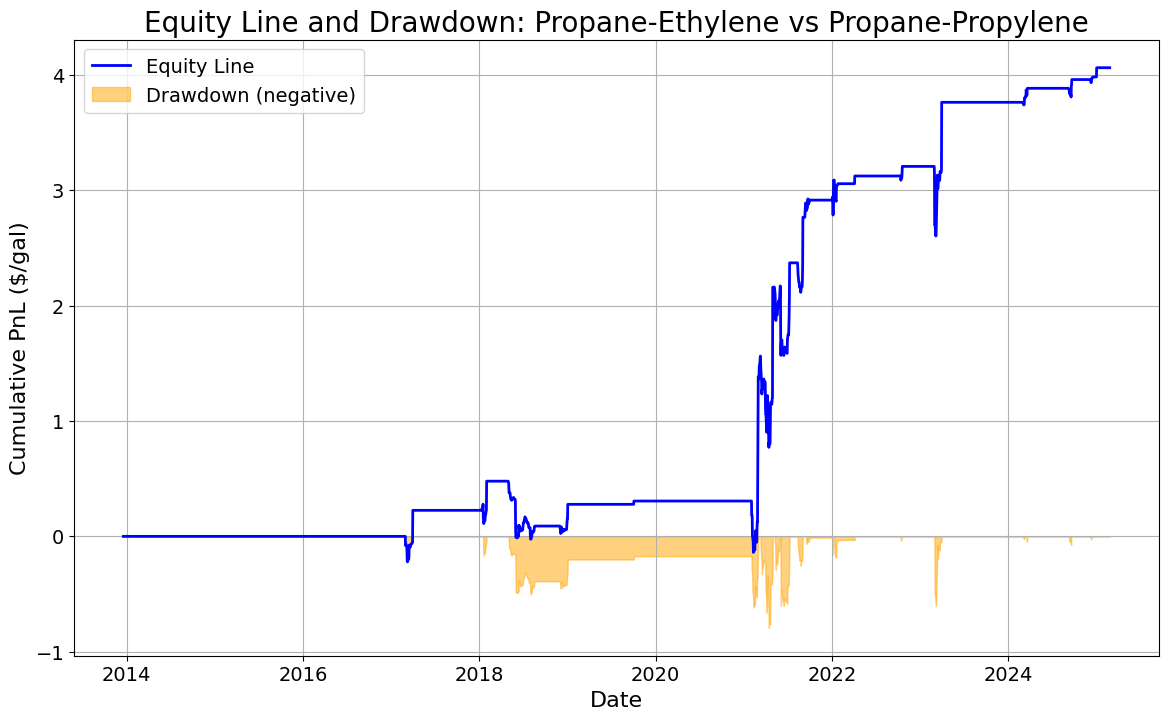

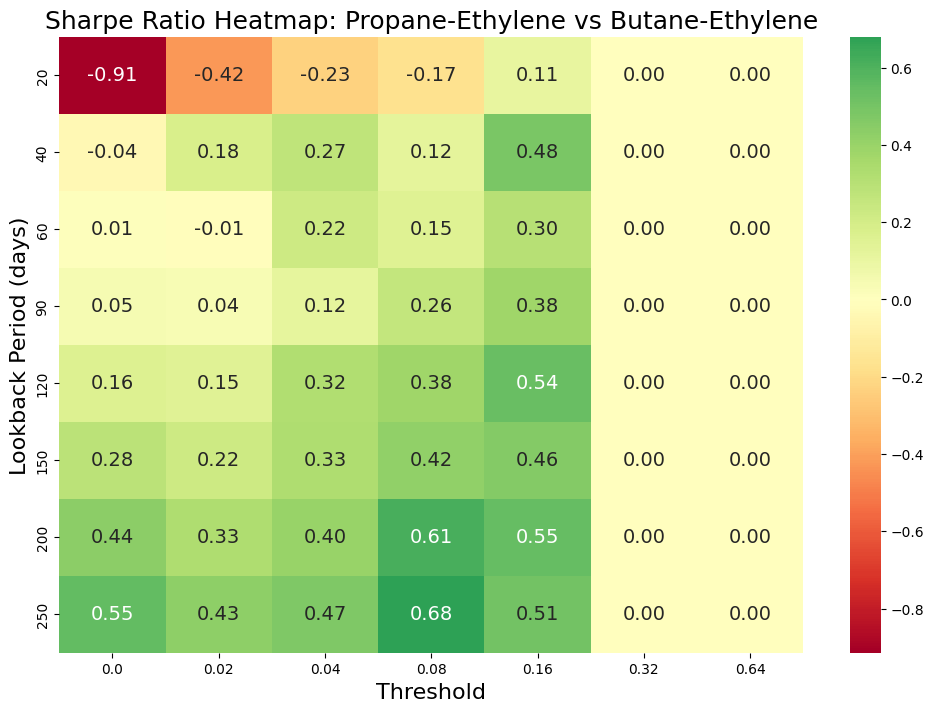


Performance Metrics for Propane-Ethylene vs Butane-Ethylene:
Annualized PnL: 0.1157
Sharpe Ratio: 0.6799
Return on Max Drawdown: 6.5566


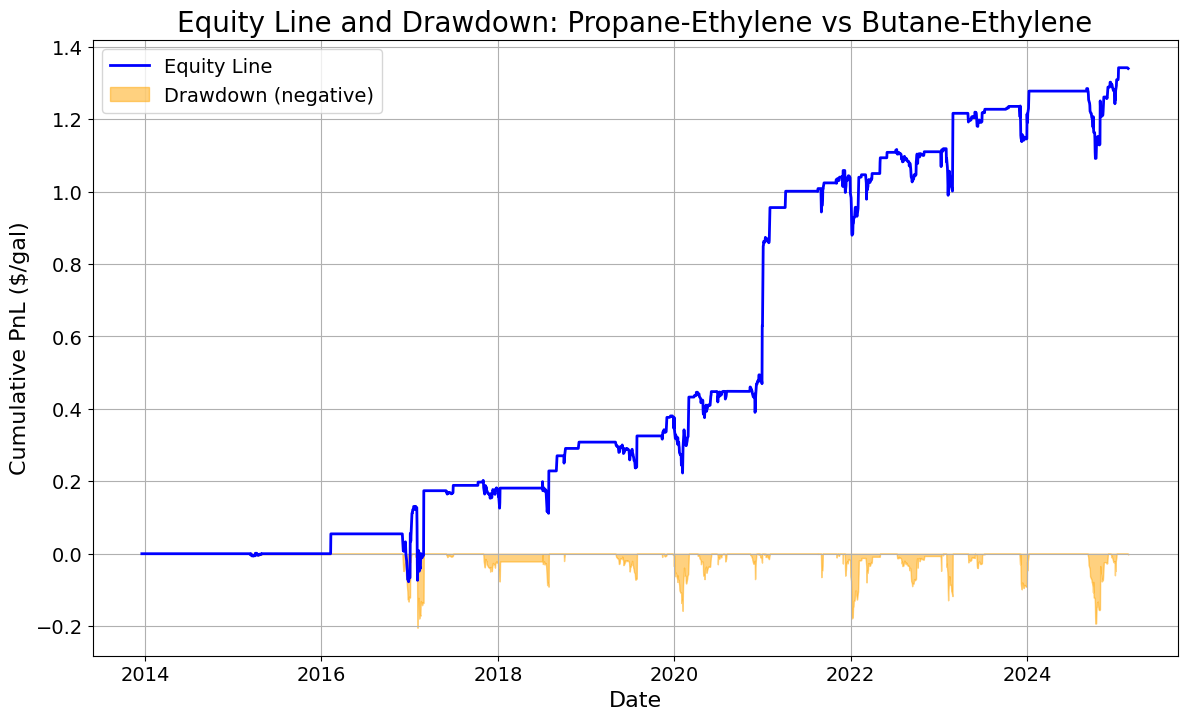

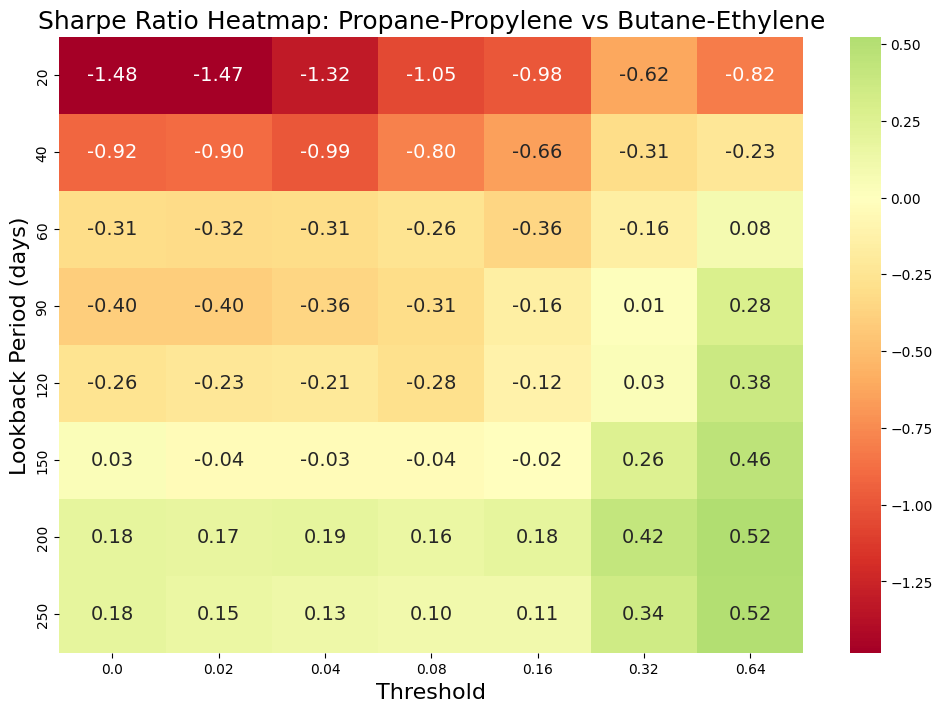


Performance Metrics for Propane-Propylene vs Butane-Ethylene:
Annualized PnL: 0.3353
Sharpe Ratio: 0.5235
Return on Max Drawdown: 4.4973


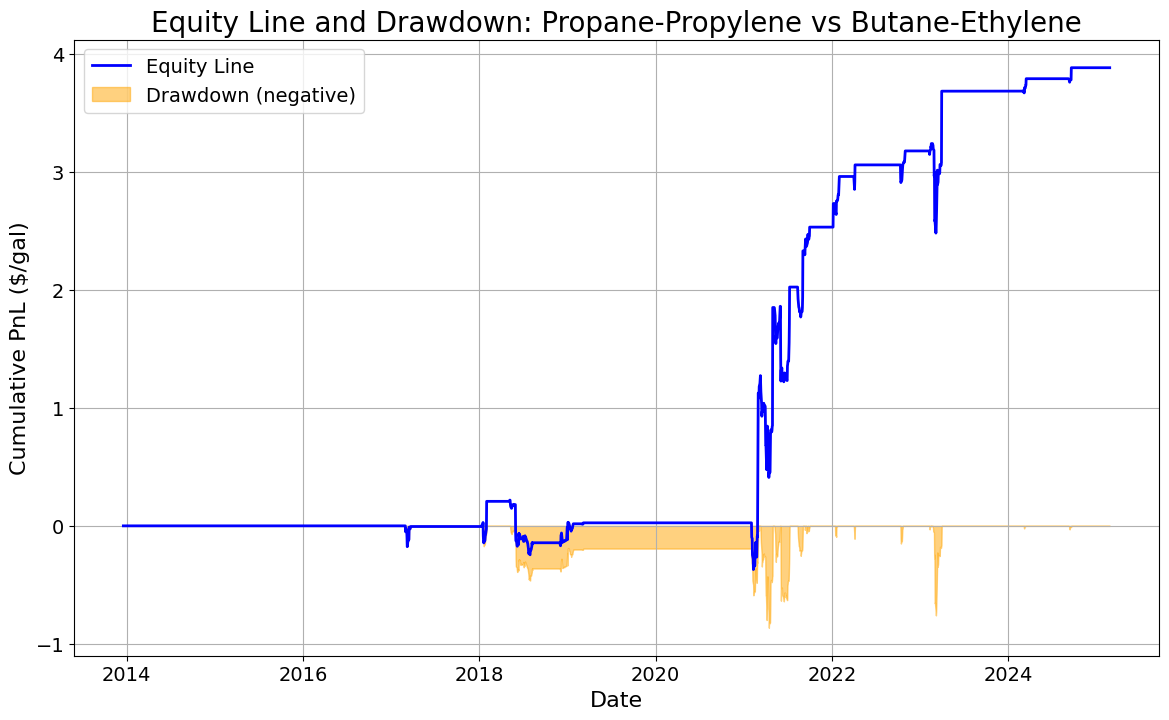

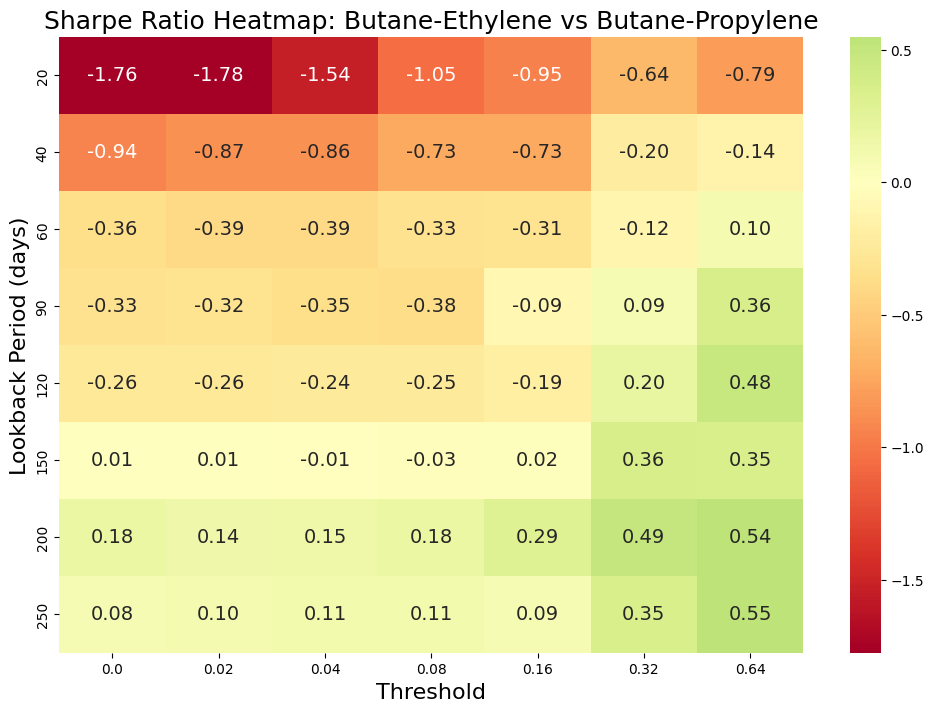


Performance Metrics for Butane-Ethylene vs Butane-Propylene:
Annualized PnL: 0.3506
Sharpe Ratio: 0.5486
Return on Max Drawdown: 5.1293


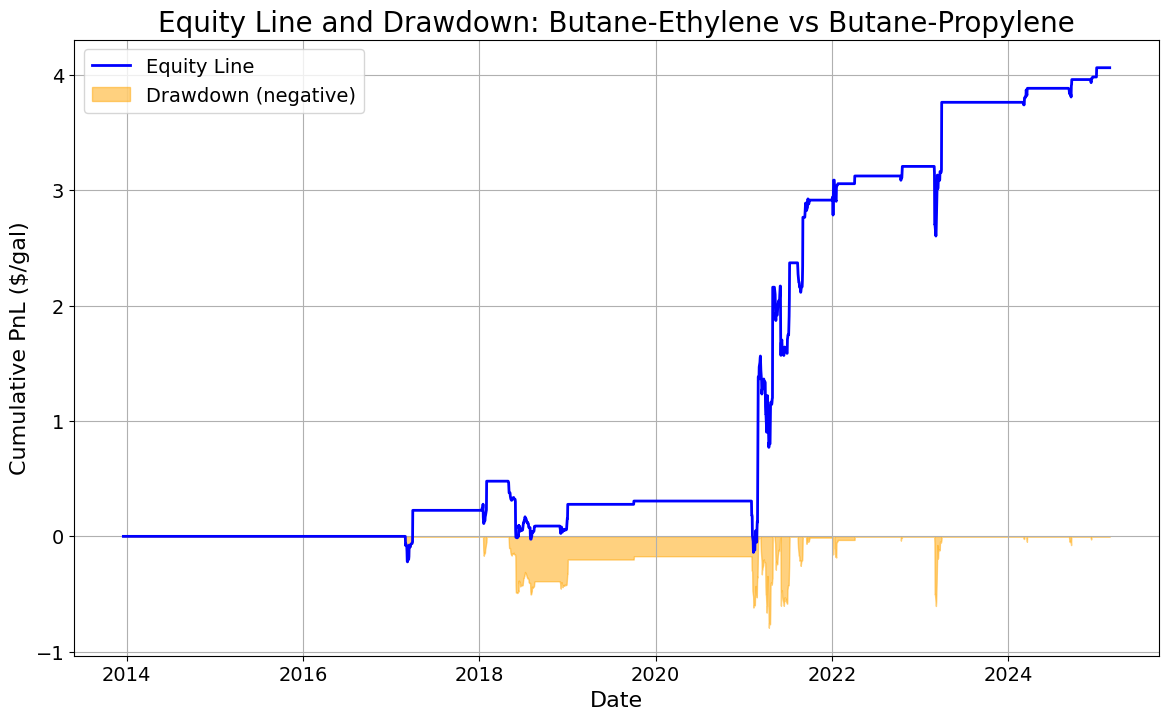

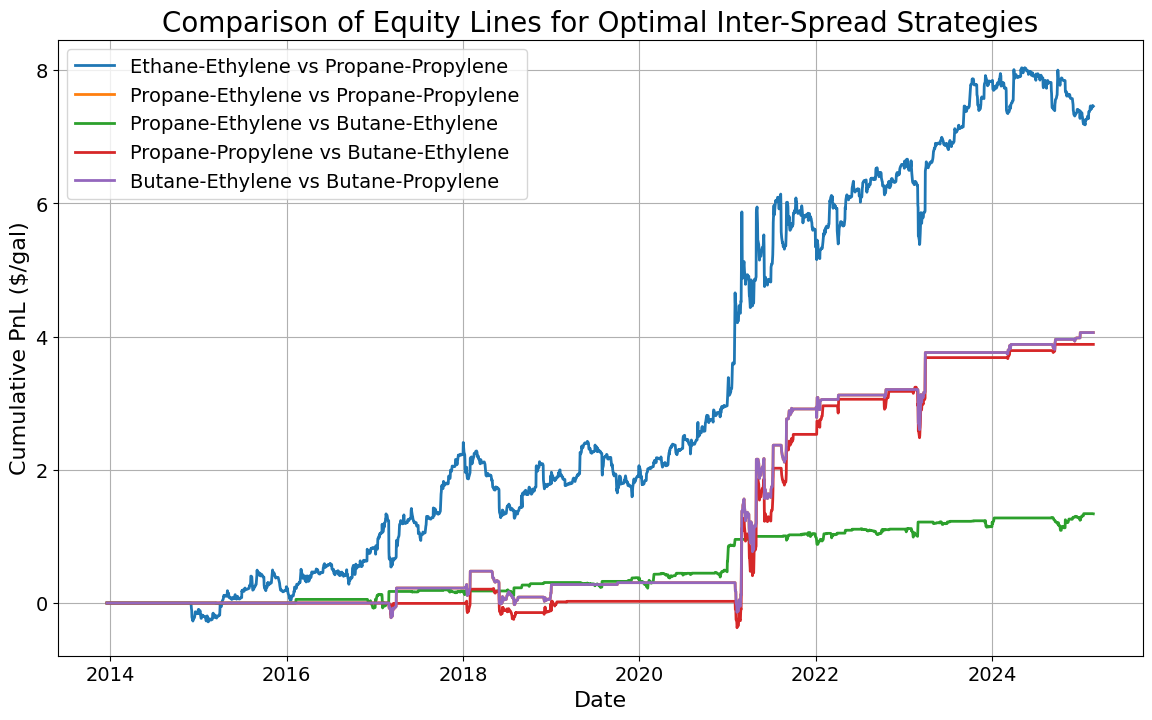

In [264]:
# ----------------------------
# 1. Performance Metrics
# ----------------------------

def calculate_sharpe_ratio(pnl_series):
    """Calculates the annualized Sharpe Ratio based on daily returns."""
    daily_returns = pnl_series.diff().dropna()
    if daily_returns.empty or daily_returns.std() == 0:
        return 0
    return (daily_returns.mean() / daily_returns.std()) * np.sqrt(252)

def calculate_annualized_pnl(pnl_series):
    """Calculates the annualized PnL based on cumulative returns."""
    pnl_series = pnl_series.dropna()
    if pnl_series.empty or pnl_series.iloc[-1] == pnl_series.iloc[0]:
        return 0
    total_days = len(pnl_series)
    total_return = pnl_series.iloc[-1] - pnl_series.iloc[0]
    return (total_return / total_days) * 252

def calculate_return_on_drawdown(cumulative_pnl):
    """Calculates the return over the maximum drawdown."""
    cumulative_pnl = cumulative_pnl.dropna()
    if cumulative_pnl.empty:
        return 0
    rolling_max = cumulative_pnl.cummax()
    drawdown = cumulative_pnl - rolling_max
    max_drawdown = drawdown.min()
    total_return = cumulative_pnl.iloc[-1] - cumulative_pnl.iloc[0]
    return 0 if max_drawdown == 0 else total_return / abs(max_drawdown)

def generate_strategy_metrics(df, spread_name):
    """Prints performance metrics for a given strategy."""
    cumulative_pnl = df['Cumulative PnL']
    annualized_pnl = calculate_annualized_pnl(cumulative_pnl)
    sharpe_ratio = calculate_sharpe_ratio(cumulative_pnl)
    return_on_dd = calculate_return_on_drawdown(cumulative_pnl)
    
    print(f"\nPerformance Metrics for {spread_name}:")
    print(f"Annualized PnL: {annualized_pnl:.4f}")
    print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
    print(f"Return on Max Drawdown: {return_on_dd:.4f}")

# ----------------------------
# 2. Signal Assignment
# ----------------------------

def assign_inter_spread_signals(df, lookback=30, threshold=0.05):
    df['MA'] = df['Spread_Diff'].rolling(window=lookback).mean()
    df['Signal'] = 0
    df.loc[df['Spread_Diff'] > df['MA'] + threshold, 'Signal'] = -1
    df.loc[df['Spread_Diff'] < df['MA'] - threshold, 'Signal'] = 1
    return df

# ----------------------------
# 3. Apply Strategy and Calculate PnL
# ----------------------------

def apply_inter_spread_strategy(df):
    df['PnL'] = df['Signal'].shift(1) * (
        (df['Intra_Spread_1'] - df['Intra_Spread_1'].shift(1)) - 
        (df['Intra_Spread_2'] - df['Intra_Spread_2'].shift(1))
    )
    df['Cumulative PnL'] = df['PnL'].cumsum()
    return df

# ----------------------------
# 4. Heatmap Data Generation
# ----------------------------

def generate_heatmap_data(df, lookbacks, thresholds):
    heatmap_data = []
    for lookback in lookbacks:
        row = []
        for threshold in thresholds:
            temp_df = assign_inter_spread_signals(df.copy(), lookback=lookback, threshold=threshold)
            temp_df = apply_inter_spread_strategy(temp_df)
            sharpe = calculate_sharpe_ratio(temp_df['Cumulative PnL'])
            row.append(sharpe)
        heatmap_data.append(row)
    return pd.DataFrame(heatmap_data, index=lookbacks, columns=thresholds)

# ----------------------------
# 5. Visualization Functions
# ----------------------------

def plot_sharpe_heatmap(heatmap_df, title):
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_df, annot=True, fmt=".2f", cmap="RdYlGn", center=0, annot_kws={"size": 14})
    plt.title(f'Sharpe Ratio Heatmap: {title}', fontsize=18)
    plt.xlabel('Threshold', fontsize=16)
    plt.ylabel('Lookback Period (days)', fontsize=16)
    plt.show()

def plot_combined_performance(df, strategy_name):
    drawdown = df['Cumulative PnL'].cummax() - df['Cumulative PnL']
    plt.figure(figsize=(14, 8))
    plt.plot(df['Date'], df['Cumulative PnL'], label='Equity Line', color='blue', linewidth=2)
    plt.fill_between(df['Date'], -drawdown, 0, color='orange', alpha=0.5, label='Drawdown (negative)')
    plt.xlabel('Date', fontsize=16)
    plt.ylabel('Cumulative PnL ($/gal)', fontsize=16)
    plt.title(f'Equity Line and Drawdown: {strategy_name}', fontsize=20)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=14)
    plt.grid()
    plt.show()

def plot_all_equity_lines(results_dict):
    plt.figure(figsize=(14, 8))
    for name, df in results_dict.items():
        plt.plot(df['Date'], df['Cumulative PnL'], label=name, linewidth=2)
    plt.xlabel('Date', fontsize=16)
    plt.ylabel('Cumulative PnL ($/gal)', fontsize=16)
    plt.title('Comparison of Equity Lines for Optimal Inter-Spread Strategies', fontsize=20)
    plt.legend(fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid()
    plt.show()

# ----------------------------
# 6. Execute Strategy
# ----------------------------

significant_pairs = [
    ('Ethane-Ethylene vs Propane-Propylene', ('CAP1 Comdty', 'PCW1 Comdty'), ('BAP1 Comdty', 'PGP1 Comdty')),
    ('Propane-Ethylene vs Propane-Propylene', ('BAP1 Comdty', 'PCW1 Comdty'), ('BAP1 Comdty', 'PGP1 Comdty')),
    ('Propane-Ethylene vs Butane-Ethylene', ('BAP1 Comdty', 'PCW1 Comdty'), ('DAE1 Comdty', 'PCW1 Comdty')),
    ('Propane-Propylene vs Butane-Ethylene', ('BAP1 Comdty', 'PGP1 Comdty'), ('DAE1 Comdty', 'PCW1 Comdty')),
    ('Butane-Ethylene vs Butane-Propylene', ('DAE1 Comdty', 'PCW1 Comdty'), ('DAE1 Comdty', 'PGP1 Comdty'))
]

lookbacks = [20, 40, 60, 90, 120, 150, 200, 250]
thresholds = [0, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64]

final_results = {}

for spread_name, (petro1_col, ngl1_col), (petro2_col, ngl2_col) in significant_pairs:
    try:
        petro1_df = calculate_eom_rolling_futures(ngl_datasets.get(petro1_col[:3]))
        ngl1_df = calculate_eom_rolling_futures(ngl_datasets.get(ngl1_col[:3]))
        petro2_df = calculate_eom_rolling_futures(ngl_datasets.get(petro2_col[:3]))
        ngl2_df = calculate_eom_rolling_futures(ngl_datasets.get(ngl2_col[:3]))

        merged_df = pd.merge(petro1_df, ngl1_df, on='Date', suffixes=('_petro1', '_ngl1')).dropna()
        merged_df = pd.merge(merged_df, petro2_df, on='Date').dropna()
        merged_df = pd.merge(merged_df, ngl2_df, on='Date', suffixes=('_petro2', '_ngl2')).dropna()

        merged_df['Intra_Spread_1'] = merged_df['Rolling Futures_petro1'] - merged_df['Rolling Futures_ngl1']
        merged_df['Intra_Spread_2'] = merged_df['Rolling Futures_petro2'] - merged_df['Rolling Futures_ngl2']
        merged_df['Spread_Diff'] = merged_df['Intra_Spread_1'] - merged_df['Intra_Spread_2']

        heatmap_df = generate_heatmap_data(merged_df, lookbacks, thresholds)
        plot_sharpe_heatmap(heatmap_df, spread_name)

        optimal_lookback, optimal_threshold = heatmap_df.stack().idxmax()

        final_df = assign_inter_spread_signals(merged_df, optimal_lookback, optimal_threshold)
        final_df = apply_inter_spread_strategy(final_df)
        final_results[spread_name] = final_df

        generate_strategy_metrics(final_df, spread_name)
        plot_combined_performance(final_df, spread_name)

    except KeyError as e:
        print(f"Data missing for {spread_name}: {e}")

# Final Comparison Plot
plot_all_equity_lines(final_results)
